In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from funcs.ffd import FFD, _get_multistar_factors

import time
tstamp = time.strftime("%d_%m_%Y_%H_%M", time.localtime())

In [2]:
df = pd.read_csv("../flare_tables/20200227_vetted_flares_lacking_some.csv",)
#                 names=['ampl_rec','cstart','cstop','ed_rec','ed_rec_err',
#                     'istart', 'istop','total_n_valid_data_points', 
#                     'tstart', 'tstop',  'dur', 'ed_ratio','ed_ratio_count',
#             'amplitude_ratio','amplitude_ratio_count','duration_ratio','duration_ratio_count',
#             'amplitude_corr','duration_corr','ed_corr','recovery_probability','recovery_probability_count',
#             'ed_ratio_std','amplitude_ratio_std','duration_ratio_std','recovery_probability_std',
#             'ed_corr_err','amplitude_corr_err','duration_corr_err',"TIC","sector","energy","st","real"
# ])
              
#spts = pd.read_csv("../flare_tables/spts.csv")

#spts.head()
#df = df.merge(spts[["TIC","spt","TESSmag"]],on="TIC")
df = df[df.real==1]
print(df.shape)
df.head()

(313, 35)


,Unnamed: 0,ampl_rec,cstart,cstop,ed_rec,ed_rec_err,istart,istop,total_n_valid_data_points,tstart,...,duration_ratio_std,recovery_probability_std,ed_corr_err,amplitude_corr_err,duration_corr_err,TIC,sector,energy,st,real
0,231,0.762096,287775,287814,1552.753649,35.008459,1315,1354,18704,1627.145175,...,0.073609,0.200000,141.864028,0.046833,0.009807,454291779,12,2.25571E+034,7.0,1.0
1,30,0.039327,304897,304901,11.984715,0.613684,17435,17439,18704,1650.925377,...,0.401894,0.501610,2.434664,0.006901,0.002603,449671564,12,6.354972E+032,6.0,1.0
5,68,0.999455,270340,270351,327.623519,6.905976,1898,1909,13204,1602.933193,...,0.528685,0.350605,29.992656,0.148482,0.001709,441000085,11,2.0024259E+032,7.0,1.0
6,137,0.035143,143992,143995,8.069187,0.484948,7600,7603,14058,1427.449927,...,0.334400,0.479899,2.799321,0.007029,0.004966,420001446,4,7.0202222E+031,6.0,1.0
7,140,0.038143,147741,147744,9.817022,0.646324,11322,11325,14058,1432.656759,...,0.334400,0.479899,3.415881,0.007630,0.004966,420001446,4,8.0306861E+031,6.0,1.0


In [ ]:
totobs = df.groupby(["TIC","sector"]).total_n_valid_data_points.apply(lambda x: x.iloc[0]).sum()/30./24./365.25

In [ ]:
totobs

In [ ]:
plt.hist(df.recovery_probability_count, bins=np.linspace(0,50,10), histtype="step");

In [ ]:
plt.hist(df.ed_ratio_count, bins=np.linspace(0,50,10), histtype="step");

In [ ]:
plt.scatter(df.ampl_rec, df.amplitude_corr)
plt.plot([0,12],[0,12])

In [ ]:
plt.hist(df.amplitude_ratio_count, bins=np.linspace(0,300,10), histtype="step");

In [ ]:
plt.hist(df.duration_ratio_count, bins=np.linspace(0,300,10), histtype="step");

In [ ]:
plt.scatter(df.ed_rec, df.ed_corr)
plt.plot([1,3e3],[1,3e3])
plt.yscale("log")
plt.xscale("log")

In [ ]:
plt.hist(df.recovery_probability, bins=np.linspace(0,1,6), histtype="step");

# target-wise FFDs

In [3]:
h = df.groupby("TIC").TIC.count().sort_values(ascending=False).head(8)
h

TIC
142052876    59
388857263    32
29928567     30
167894019    26
272349442    20
29780677     20
220429097    13
395130640     8
Name: TIC, dtype: int64

/home/ekaterina/Documents/001_Science/TESS_UCDs/TESS_UCD_flares/notebook/funcs/ffd.py:336: UserWarning: Kolmogorov-Smirnov tells us to reject the power law hypothesis at p=0.05. KS=0.22036248065558173, limit=0.1768097573356775
  ' KS={}, limit={}'.format(sig_level, KS, limit))


1.5762564448987018 0.1308188815990068 False False
1.462576345670021 0.2555901272753836 True True
456
1.0000022888183566 4.736373295277994e-15 False True


/home/ekaterina/Documents/001_Science/TESS_UCDs/TESS_UCD_flares/notebook/funcs/ffd.py:336: UserWarning: Kolmogorov-Smirnov tells us to reject the power law hypothesis at p=0.05. KS=0.3802368225821149, limit=0.06359893051651284
  ' KS={}, limit={}'.format(sig_level, KS, limit))


Text(0, 0.5, 'cumulative number of flares per year')

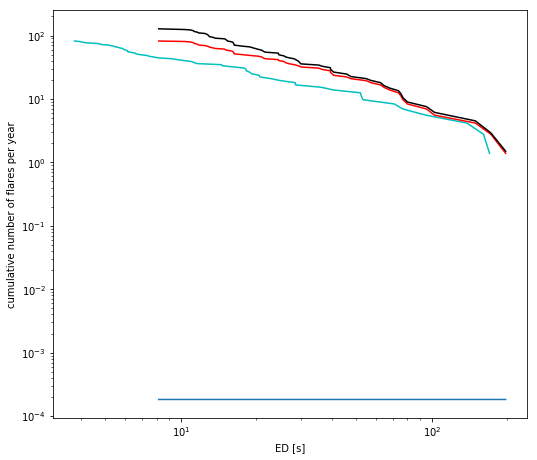

In [8]:
d = df[df.TIC==h.index[0]]
tobs =  d.groupby(["sector"]).total_n_valid_data_points.apply(lambda x: x.iloc[0]).sum()/30./24./365.25

ffd = FFD(f=d, tot_obs_time=tobs)
fig, ax = plt.subplots(1,figsize=(8.5,7.5))
ed, freq, counts = ffd.ed_and_freq( energy_correction=False,
                            recovery_probability_correction=False,
                             multiple_stars=False)
a, sig_a = ffd.fit_powerlaw(d.ed_rec.values)
ffd.alpha, ffd.alpha_err = a, sig_a
ispowerlaw = ffd.is_powerlaw(d.ed_rec.values)
truncated = ffd.is_powerlaw_truncated(d.ed_rec.values)
print(a, sig_a, ispowerlaw, truncated)

ax.plot(ed, freq, c="c", label="no correction")

ed, freq, counts = ffd.ed_and_freq( energy_correction=True,
                            recovery_probability_correction=False,
                             multiple_stars=False)
a, sig_a = ffd.fit_powerlaw(d.ed_corr.values)
ffd.alpha, ffd.alpha_err = a, sig_a
ispowerlaw = ffd.is_powerlaw(d.ed_corr.values)
truncated = ffd.is_powerlaw_truncated(d.ed_corr.values)
print(a, sig_a, ispowerlaw, truncated)

ax.plot(ed, freq, c="r", label="ED correction")


eds, freq = [], []
for n, ED, f in zip(np.rint(5*(1/d.recovery_probability)), 
                    df.ed_rec.sort_values(ascending=True), 
                    (1./d.recovery_probability).values):
    eds.append(int(n)*[ED])
    freq.append(int(n)*[f])
    
eds = np.array([i  for a in eds for i in a])
freq = np.array([i  for a in freq for i in a])
print(len(eds))
a, sig_a = ffd.fit_powerlaw(eds)
ffd.alpha, ffd.alpha_err = a, sig_a*1e13
ispowerlaw = ffd.is_powerlaw(eds)
truncated = ffd.is_powerlaw_truncated(eds)
print(a, sig_a, ispowerlaw, truncated)
ed, freq, counts = ffd.ed_and_freq( energy_correction=True,
                            recovery_probability_correction=True,
                             multiple_stars=False)
_beta, ffd.beta, ffd.beta_err = ffd.fit_beta_to_powerlaw(ed, freq)
ax.plot(ed, freq, c="k", label="ED and rec. prob. correction")
ffd.plot_powerlaw(ax, ed)

plt.xscale('log')
plt.yscale('log')
plt.xlabel("ED [s]")#"flare energy in TESS band [erg]")
plt.ylabel("cumulative number of flares per year")

In [ ]:
df = df[~np.isnan(df.recovery_probability) & (df.recovery_probability > 0.2)]
df = df.sort_values(by="ed_corr", ascending=False)
df = df[~df.ed_corr.isnull() & np.isfinite(df.ed_corr) & (df.ed_corr > 6)]

ffd = FFD(df,ID="TIC")
ffd.alpha, ffd.alpha_err = 2., .2
ffd.tot_obs_time = 1.

fig, ax = plt.subplots(1,figsize=(8.5,7.5))

# No correction, single star mode
ed, freq, counts = ffd.ed_and_freq( energy_correction=False,
                            recovery_probability_correction=False,
                             multiple_stars=False)
ax.plot(ed, freq, c="c", label="no correction",alpha=.2)
_beta, ffd.beta, beta_err = ffd.fit_beta_to_powerlaw(ed,freq, mode="ED")
ffd.plot_powerlaw(ax, ed, c="k", alpha=.2,)
plt.xscale('log')
plt.yscale('log')

In [ ]:
a, sig_a = ffd.fit_powerlaw(df.ed_rec.values)
ispowerlaw = ffd.is_powerlaw(df.ed_rec.values)
truncated = ffd.is_powerlaw_truncated(df.ed_rec.values)

print(a, sig_a, ispowerlaw, truncated)

In [ ]:
ed, freq, counts = ffd.ed_and_freq( energy_correction=True,
                            recovery_probability_correction=True,
                             multiple_stars=True)
eds = []
for n, ED in zip(np.rint((1/counts)*56), df.ed_rec.sort_values(ascending=True)):
    eds.append(int(n)*[ED])
eds =[i  for a in eds for i in a]

In [ ]:
len(eds)

In [ ]:
a, sig_a = ffd.fit_powerlaw(eds)
a, sig_a

In [ ]:
ffd.alpha = a
ffd.alpha_err = sig_a

In [ ]:
ispowerlaw = ffd.is_powerlaw(np.array(eds))
ispowerlaw

In [ ]:
truncated = ffd.is_powerlaw_truncated(eds)

print(a, sig_a, ispowerlaw, truncated)

In [ ]:
_get_multistar_factors(df, "TIC", "ed_corr")


In [ ]:
# ED correction, single star mode
ed, freq = ffd.ed_and_freq( energy_correction=True,
                            recovery_probability_correction=False,
                             multiple_stars=False)
ax.scatter(ed, freq, c="c", label="ED correction",alpha=.5)
_beta, beta, beta_err = ffd.fit_beta_to_powerlaw(ed,freq, mode="ED")
ffd.plot_powerlaw(ax, ed, c="k",alpha=.5, )


# ED and recprob correction, single star mode
ed, freq = ffd.ed_and_freq( energy_correction=True,
                            recovery_probability_correction=True,
                             multiple_stars=False)
ax.scatter(ed, freq, c="c",alpha=1, label="ED and recprob correction")
_beta, beta, beta_err = ffd.fit_beta_to_powerlaw(ed,freq, mode="ED")
ffd.plot_powerlaw(ax, ed, c="k",alpha=1, )




# No correction, multiple star mode
ed, freq = ffd.ed_and_freq( energy_correction=False,
                            recovery_probability_correction=False,
                             multiple_stars=True)
ax.scatter(ed, freq, c="r", label="no correction",alpha=.2)
_beta, beta, beta_err = ffd.fit_beta_to_powerlaw(ed,freq, mode="ED")
ffd.plot_powerlaw(ax, ed, c="k", alpha=.2, )

# ED correction, multiple star mode
ed, freq = ffd.ed_and_freq( energy_correction=True,
                            recovery_probability_correction=False,
                             multiple_stars=True)
ax.scatter(ed, freq, c="r", label="ED correction",alpha=.5)
_beta, beta, beta_err = ffd.fit_beta_to_powerlaw(ed,freq, mode="ED")
ffd.plot_powerlaw(ax, ed, c="k",alpha=.5, )


# ED and recprob correction, multiple star mode
ed, freq = ffd.ed_and_freq( energy_correction=True,
                            recovery_probability_correction=True,
                             multiple_stars=True)
ax.scatter(ed, freq, c="r",alpha=1, label="ED and recprob correction")
_beta, beta, beta_err = ffd.fit_beta_to_powerlaw(ed,freq, mode="ED")
ffd.plot_powerlaw(ax, ed, c="k",alpha=1, )


plt.xscale('log')
plt.yscale('log')
plt.xlabel("ED [s]")#"flare energy in TESS band [erg]")
plt.ylabel("cumulative number of flares per year")
# #plt.title(spt)
plt.legend(fontsize=14)
# #     plt.figure(figsize=(6.5,5.5))
# #     plt.hist(df.TESSmag)
# #     plt.title(spt)

# plt.ylim(.1,1e3)
# plt.xlim(1,10000)
# # for x,z in zip(a,f):
# #     print(x,z)
# # print(df.shape)
# plt.savefig(f"../plots/{tstamp}_FFD_two_step_correction.png".format(tstamp), dpi=300)

In [ ]:
ed, freq = ffd.ed_and_freq( energy_correction=True,
                            recovery_probability_correction=True,
                             multiple_stars=True)
ffd.is_powerlaw(ed),  ffd.is_powerlaw_truncated(ed)

In [ ]:
#df = df[df.recovery_probability > .2]


df = df.sort_values(by="ed_rec", ascending=False)
#df['probnocorrcum'] = np.cumsum(1/np.array(freq[::-1])*freq[-1])
df['probnocorrcum'] = np.cumsum(np.ones_like(freq))
df['sortededrec'] =df.ed_rec.sort_values(ascending=False)
df = df.sort_values(by="ed_corr", ascending=False)
df = df[(~df.ed_corr.isnull()) & (np.isfinite(df.ed_corr)) & (df.recovery_probability >0.0) ]
df["ed_corrprob"] = 1/df.recovery_probability.values
df["ed_corrprob_err"] = df.recovery_probability_std / df.recovery_probability**2
df["ed_corrprobcum"] = np.cumsum(df.ed_corrprob.values)


plt.figure(figsize=(6.5,5.5))
for l, row in df.iterrows():
    plt.plot([row.sortededrec, row.ed_corr], [row.probnocorrcum, row.ed_corrprobcum],c="grey",alpha=.5)
plt.scatter(df["sortededrec"], df["probnocorrcum"], label="no correction", c="k")#, condition {}".format(label))
plt.scatter(df.ed_corr, df["ed_corrprobcum"], label="energy ratio and recovery probability correction", c="r")#, condition {}".format(label))
plt.plot([10, 4000],[4000, 10], label="slope=-1", linestyle="dashed", c="grey", linewidth=3)
plt.xscale('log')
plt.yscale('log')
#plt.ylim(.8,250)
#plt.xlim(5,4000)
plt.xlabel("ED [s]")#"flare energy in TESS band [erg]")
plt.ylabel("cumulative number of flares")
plt.legend()
#plt.savefig("plots/{}_FFD_flare_correspondence_correction.png".format(today), dpi=300)

In [ ]:
f
